In [1]:
import analyzeData
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from urllib import parse

np.set_printoptions(threshold=sys.maxsize)
my_analyzer = analyzeData.ClearUpAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kayash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kayash/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
tweets = pd.read_csv("dataset/train.csv")

**Оценка данных**

На первом этапе посмотрим состав данных. Каков их размер, сбалансирована выборка или нет, какие ключевые слова имеем. Рассмотрим длину предложений в зависимости от цели.

In [3]:
tweets.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [4]:
tweets.shape

(7613, 5)

In [5]:
tweets.target.value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

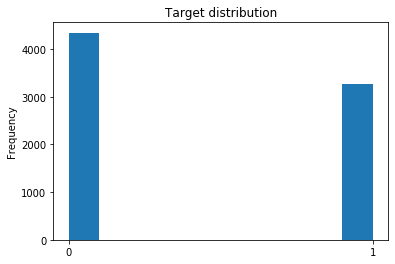

In [6]:
tweets.target.plot(y='Frequancy', kind='hist',  title='Target distribution', xticks=[0,1])
plt.show()

//---------- Далее нмного почистим текст, ключевые слова и локации ----------//


In [7]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].replace(np.nan, '', regex=True)
    df[text_field] = df[text_field].apply(lambda x: parse.unquote(x))
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.lower()
    return df

tweets = standardize_text(tweets, "text")
tweets = standardize_text(tweets, "keyword")
tweets = standardize_text(tweets, "location")

tweets['tokens'] = tweets['text'].apply(lambda x: my_analyzer(x))

tweets.to_csv("dataset/clean_train.csv")

tweets.head()

id keyword location                                               text  \
0   1                   our deeds are the reason of this  earthquake m...   
1   4                              forest fire near la ronge sask  canada   
2   5                   all residents asked to 'shelter in place' are ...   
3   6                   13,000 people receive  wildfires evacuation or...   
4   7                   just got sent this photo from ruby  alaska as ...   

   target                                             tokens  
0       1  [deed, reason, earthquake, may, allah, forgive...  
1       1      [forest, fire, near, la, ronge, sask, canada]  
2       1  [resident, asked, shelter, place, notified, of...  
3       1  [13000, people, receive, wildfire, evacuation,...  
4       1  [got, sent, photo, ruby, alaska, smoke, wildfi...

In [8]:
keywords = pd.DataFrame({"name":tweets.keyword.value_counts(normalize=True).index.tolist(),
             "weight":tweets.keyword.value_counts(normalize=True).tolist()})
keywords.sort_values(['weight'], ascending=False)

name    weight
0                         0.008013
1             fatalities  0.005911
2             armageddon  0.005517
3                 deluge  0.005517
4                 damage  0.005386
..                   ...       ...
217          forest fire  0.002496
218            epicentre  0.001576
219               threat  0.001445
220           inundation  0.001314
221  radiation emergency  0.001182

[222 rows x 2 columns]

In [9]:
locations = pd.DataFrame({"name":tweets.location.value_counts(normalize=True).index.tolist(),
             "weight":tweets.location.value_counts(normalize=True).tolist()})
locations.sort_values(['weight'], ascending=False)

name    weight
0                                  0.333114
1                             usa  0.013661
2                        new york  0.009852
3                   united states  0.006568
4                          london  0.006436
...                           ...       ...
1430  my rts are not endorsements  0.000131
1431                  manila city  0.000131
1432               youngstown, oh  0.000131
1433      l s z l t h c h r a s c  0.000131
3226              london new york  0.000131

[3227 rows x 2 columns]

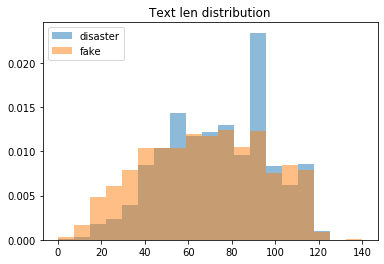

In [10]:
tweets['text_len'] = tweets['text'].apply(lambda x: len(x) - x.count(" "))

bins = np.linspace(0, 140, 20)
plt.hist(tweets[tweets['target']==1]['text_len'], bins, alpha=0.5, density=True, label='disaster')
plt.hist(tweets[tweets['target']==0]['text_len'], bins, alpha=0.5, density=True, label='fake')
plt.legend(loc='upper left')
plt.title('Text len distribution')
plt.show()

In [11]:
import string

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

tweets['text_punct'] = tweets['text'].apply(lambda x: count_punct(x))

tweets.head()

id keyword location                                               text  \
0   1                   our deeds are the reason of this  earthquake m...   
1   4                              forest fire near la ronge sask  canada   
2   5                   all residents asked to 'shelter in place' are ...   
3   6                   13,000 people receive  wildfires evacuation or...   
4   7                   just got sent this photo from ruby  alaska as ...   

   target                                             tokens  text_len  \
0       1  [deed, reason, earthquake, may, allah, forgive...        56   
1       1      [forest, fire, near, la, ronge, sask, canada]        31   
2       1  [resident, asked, shelter, place, notified, of...       111   
3       1  [13000, people, receive, wildfire, evacuation,...        56   
4       1  [got, sent, photo, ruby, alaska, smoke, wildfi...        70   

   text_punct  
0         0.0  
1         0.0  
2         1.8  
3         1.8  
4         0.0

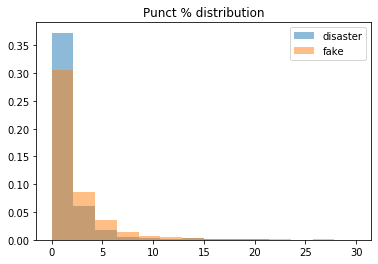

In [12]:
bins = np.linspace(0, 30, 15)
plt.hist(tweets[tweets['target']==1]['text_punct'], bins, alpha=0.5, density=True, label='disaster')
plt.hist(tweets[tweets['target']==0]['text_punct'], bins, alpha=0.5, density=True, label='fake')
plt.legend(loc='upper right')
plt.title('Punct % distribution')
plt.show()

// ------- Перемешаем данные ----- //

In [13]:
from sklearn.utils import shuffle

tweets = shuffle(tweets, random_state=2)

**Токенизируем. TFIDF Bag of Words**

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

Для начала разобьем текст на тестовую и обучающую выборку

In [15]:
list_text = tweets["text"].tolist()
list_labels = tweets["target"].tolist()

X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(list_text, list_labels, test_size=0.3, 
                                                                                random_state=40)

In [16]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(tokenizer=my_analyzer)

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_text_train_tfidf, tfidf_vectorizer = tfidf(X_text_train)
X_text_test_tfidf = tfidf_vectorizer.transform(X_text_test)

In [17]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=mcolors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Fake')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

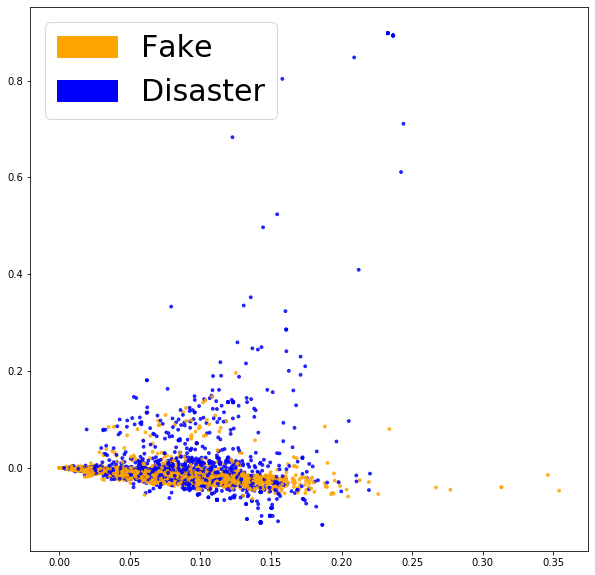

In [18]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_text_train_tfidf, y_text_train)
plt.show()

In [19]:
clf_tfidf = LogisticRegression(solver='newton-cg', random_state=2)
clf_tfidf.fit(X_text_train_tfidf, y_text_train)

y_predicted_tfidf = clf_tfidf.predict(X_text_test_tfidf)

In [20]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_text_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf))

accuracy = 0.811, precision = 0.814, recall = 0.811, f1 = 0.808


// ----- Исследуем полученные результаты ----- //

Confusion matrix, without normalization
[[1170  134]
 [ 297  683]]
Normalized confusion matrix
[[0.89723926 0.10276074]
 [0.30306122 0.69693878]]


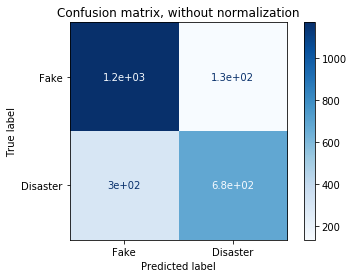

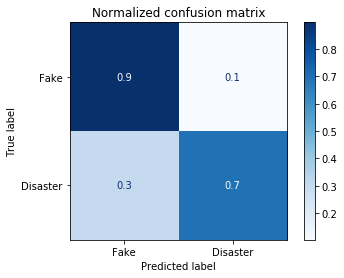

In [97]:
from sklearn.metrics import confusion_matrix,  plot_confusion_matrix

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

classes=['Fake','Disaster']
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_tfidf, X_text_test_tfidf, y_text_test,
                                 display_labels=classes,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

In [22]:
y_text_test.count(0), y_text_test.count(1)

(1304, 980)

 // ----- Определим самые важные признаки ----- //

In [23]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance_tgidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 15)

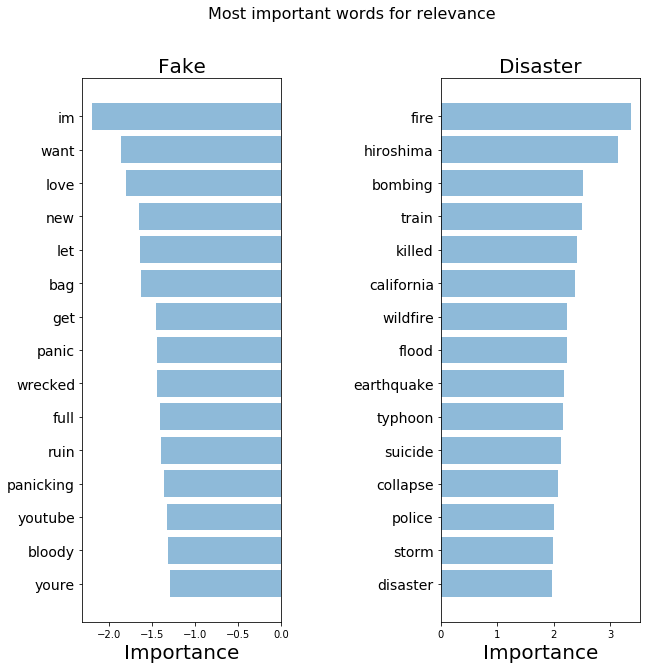

In [24]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Fake', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance_tgidf[0]['tops']]
top_words = [a[1] for a in importance_tgidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tgidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tgidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

**TFIDF N-GRAM**

In [25]:
def tfidf_ngram(data):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 4), tokenizer=my_analyzer)

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_text_train_tfidf_ngram, tfidf_vectorizer_ngram = tfidf_ngram(X_text_train)
X_text_test_tfidf_ngram = tfidf_vectorizer_ngram.transform(X_text_test)

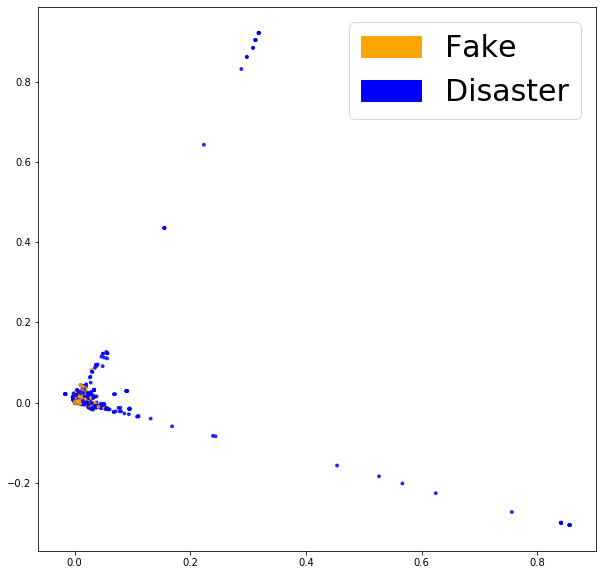

In [26]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_text_train_tfidf_ngram, y_text_train)
plt.show()

In [27]:
clf_tfidf_ngram = LogisticRegression(solver='newton-cg', random_state=2)
clf_tfidf_ngram.fit(X_text_train_tfidf_ngram, y_text_train)

y_predicted_tfidf_ngram = clf_tfidf_ngram.predict(X_text_test_tfidf_ngram)

In [28]:
accuracy_tfidf_ngram, precision_tfidf_ngram, recall_tfidf_ngram, f1_tfidf_ngram = get_metrics(y_text_test, y_predicted_tfidf_ngram)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf_ngram, precision_tfidf_ngram, recall_tfidf_ngram, f1_tfidf_ngram))

accuracy = 0.807, precision = 0.814, recall = 0.807, f1 = 0.802


Confusion matrix, without normalization
[[1194  110]
 [ 331  649]]
Normalized confusion matrix
[[0.91564417 0.08435583]
 [0.3377551  0.6622449 ]]


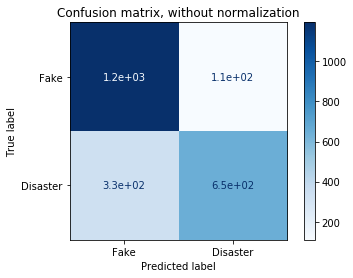

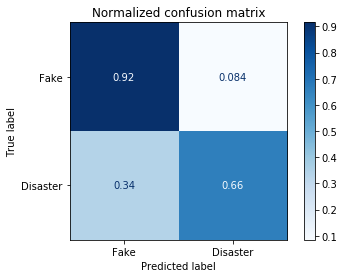

In [29]:
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_tfidf_ngram, X_text_test_tfidf_ngram, y_text_test,
                                 display_labels=classes,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

In [30]:
importance_tgidf_ngram = get_most_important_features(tfidf_vectorizer_ngram, clf_tfidf_ngram, 15)

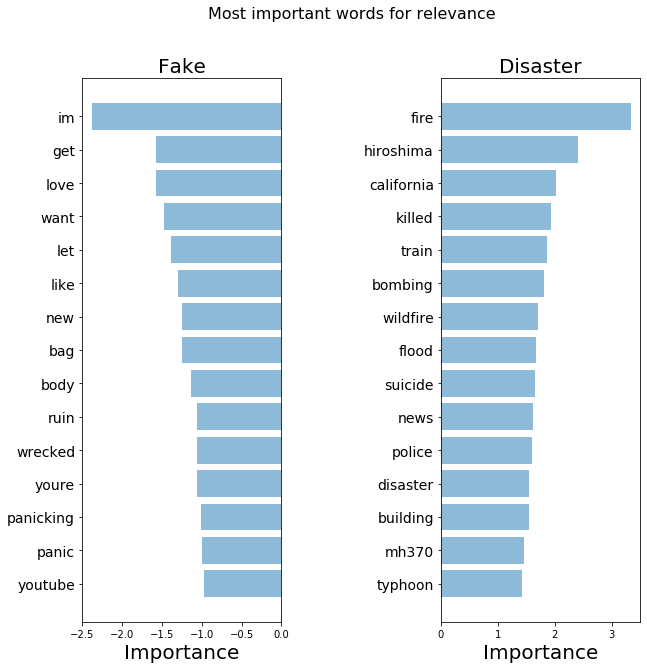

In [31]:
top_scores_ngram = [a[0] for a in importance_tgidf_ngram[0]['tops']]
top_words_ngram = [a[1] for a in importance_tgidf_ngram[0]['tops']]
bottom_scores_ngram = [a[0] for a in importance_tgidf_ngram[0]['bottom']]
bottom_words_ngram = [a[1] for a in importance_tgidf_ngram[0]['bottom']]

plot_important_words(top_scores_ngram, top_words_ngram, bottom_scores_ngram, bottom_words_ngram, "Most important words for relevance")

**Word Embedding и Word2Vec**

In [32]:
import nltk
from nltk.corpus import abc
import gensim

nltk.download('abc')
nltk.download('punkt')

[nltk_data] Downloading package abc to /Users/kayash/nltk_data...
[nltk_data]   Package abc is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kayash/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

// ------ Тут я тестирую то, что в презентации по BI было предложено ------ //

In [33]:
model= gensim.models.Word2Vec(abc.sents(), size=200) # так обучается модель на 

X = list(model.wv.vocab)

data=model.wv.most_similar('science')

In [34]:
len(X)

10363

// ----- Конец тестов, начало нормальной работы ------ //

In [71]:
# Тут самостоятельно придется скачать файлик (https://code.google.com/archive/p/word2vec/)
word2vec_path = "dataset/GoogleNews-vectors-negative300.bin.gz" 
# Эта модель генерирует вектора размерности 300
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True) # скачала набор слов

In [85]:
word2vec.vector_size

300

In [86]:
len(list(word2vec.vocab))

3000000

In [87]:
from itertools import islice
list(islice(word2vec.vocab, 13030, 13040))

['Memorial_Hospital',
 'Seniors',
 'memorandum',
 'elephant',
 'Trump',
 'Census',
 'pilgrims',
 'De',
 'Dogs',
 '###-####_ext']

In [88]:
# Тут модель загружается по ходу
# import gensim.downloader as api
# word2vec = api.load('word2vec-google-news-300')

In [89]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0) # из n векторов делаем 1
    averaged = np.divide(summed, length) # считаем среднее значение
    return averaged

def get_word2vec_embeddings(vectors, tweets, generate_missing=False):
    embeddings = tweets['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [90]:
embeddings = get_word2vec_embeddings(word2vec, tweets)

In [91]:
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.3, random_state=40)

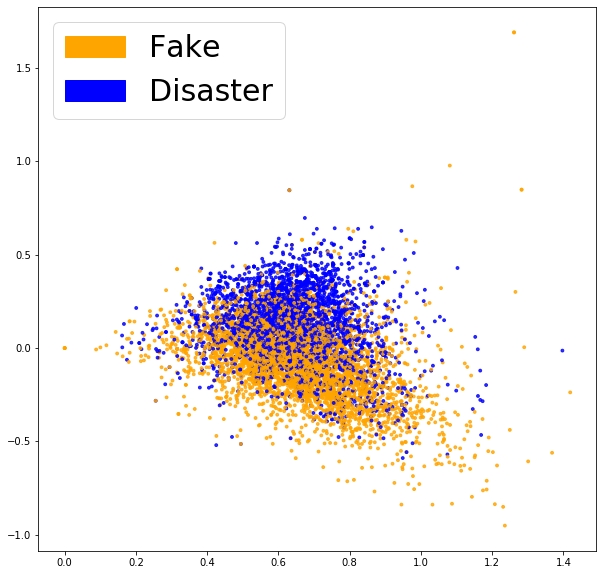

In [92]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(embeddings, list_labels)
plt.show()

In [93]:
clf_w2v = LogisticRegression(solver='newton-cg', random_state=2)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [94]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.793, precision = 0.792, recall = 0.793, f1 = 0.791


Confusion matrix, without normalization
[[1112  192]
 [ 281  699]]
Normalized confusion matrix
[[0.85276074 0.14723926]
 [0.28673469 0.71326531]]


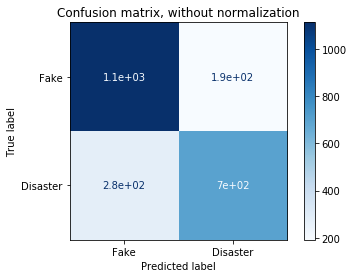

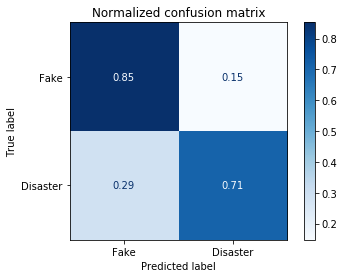

In [98]:
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_w2v, X_test_word2vec, y_text_test,
                                 display_labels=classes,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

// ----- Вписываю какой-то огромный кусок кода вместе с lime библиоткой для визуализации словечек -----//

In [99]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
from nltk.tokenize import RegexpTokenizer

In [100]:
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(tfidf_vectorizer, clf_tfidf)

In [101]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6, num_samples=100)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["irrelevant","relevant"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [102]:
visualize_one_exp(X_text_test, y_text_test, 65)

Index: 65
True class: relevant


In [103]:
visualize_one_exp(X_text_test, y_text_test, 20)

Index: 20
True class: irrelevant


In [104]:
import random
from collections import defaultdict

random.seed(40)

In [105]:
def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Irrelevant',
    1: 'Relevant'
}
sorted_contributions = get_statistical_explanation(X_text_test, 100, word2vec_pipeline, label_to_text)

/Users/kayash/.conda/envs/big_data/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


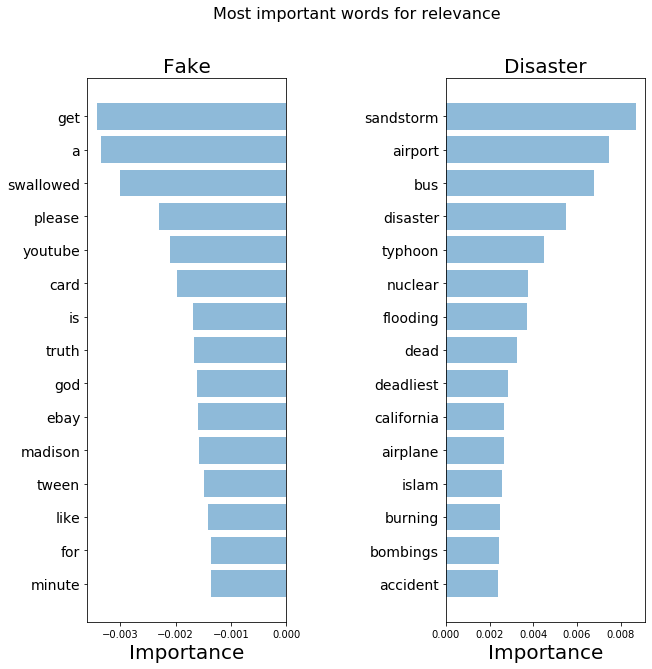

In [106]:
# First index is the class (Disaster)
# Second index is 0 for detractors, 1 for supporters
# Third is how many words we sample
top_words = sorted_contributions['Relevant']['supporters'][:15].index.tolist()
top_scores = sorted_contributions['Relevant']['supporters'][:15].tolist()
bottom_words = sorted_contributions['Relevant']['detractors'][:15].index.tolist()
bottom_scores = sorted_contributions['Relevant']['detractors'][:15].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Сохраним модель clf_w2v

In [361]:
import pickle

In [363]:
# save the model to disk
pickle.dump(clf_w2v, open('readyModels/clrW2vModel.sav', 'wb'))

In [364]:
#read
clf_w2v_loaded = pickle.load(open('readyModels/clrW2vModel.sav', 'rb'))

In [366]:
y_predicted_word2vec_loaded = clf_w2v_loaded.predict(X_test_word2vec)
accuracy_word2vec_loaded, precision_word2vec_loaded, recall_word2vec_loaded, f1_word2vec_loaded = get_metrics(y_test_word2vec, y_predicted_word2vec_loaded)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec_loaded, precision_word2vec_loaded, 
                                                                       recall_word2vec_loaded, f1_word2vec_loaded))

accuracy = 0.793, precision = 0.792, recall = 0.793, f1 = 0.791


**CNN for sentence classification**

Используя полученные вектора из word2vec для слов будем учитывать порядок слов в предложении используя сверточную нейронную сеть

In [107]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [108]:
tweets['clean_text'] = tweets["tokens"].apply(lambda x: " ".join(str(t) for t in x))

In [109]:
all_words = [word for tokens in tweets['tokens'] for word in tokens]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))

79559 words total, with a vocabulary size of 15647


In [110]:
sentence_lengths = [len(tokens) for tokens in tweets["tokens"]]
print("Max sentence length is %s" % max(sentence_lengths))

Max sentence length is 28


In [111]:
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 30
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.3 # разбиение на тестовую и обучающую выборку
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(tweets['clean_text'].tolist())
sequences = tokenizer.texts_to_sequences(tweets["clean_text"].tolist()) 

texts_to_sequences - функция, которая переводит текст в последовательность целых чисел путем а) токенизации, то есть разбиения строки на токены и б) замены каждого токена на его номер в словаре. 


In [112]:
word_index = tokenizer.word_index
print(word_index['fire'], word_index['bomb'])
print('Found %s unique tokens.' % len(word_index))

1 35
Found 15646 unique tokens.


tokenizer.word_index массим где ключ -это слово, а значение его порядковый номер. Грубо говоря - это тот самый словарь

In [113]:
cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
cnn_data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 1354,
         25,    1,  898,   94,  175,   37,  484,   18], dtype=int32)

Выравниваем получившуюся последовательность, тк CNN Может работать толькл с матрицами фиксированного размера

In [114]:
labels = to_categorical(np.asarray(tweets["target"]))
labels[0:3], tweets["target"][0:3]

(array([[1., 0.],
        [1., 0.],
        [0., 1.]], dtype=float32), 3190    0
 6171    0
 1196    1
 Name: target, dtype: int64)

Преобразовываем метки классов к матричному виду для обучения с помощью кросс-энтропии. Для этого мы переведем номер класса в так называемый one-hot вектор, т.е. вектор, состоящий из нулей и одной единицы

In [115]:
indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data_shuffled = cnn_data[indices]
labels_shuffled = labels[indices]

Создаем индексы, перемешиваем их и перемешиваем нашу последовательность предложений и целевые значения. И никогда не используем. Ха-ха

In [116]:
num_test_samples = int(VALIDATION_SPLIT * cnn_data_shuffled.shape[0])
num_test_samples, cnn_data_shuffled.shape[0], VALIDATION_SPLIT # число твитов в тестовой выборке

(2283, 7613, 0.3)

Ниже создаем нулевую матрицу (размер_словаря х размерность_word2vec_вектора) и заполняем ее значениями из словаря word2vec

In [117]:
embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.zeros(EMBEDDING_DIM) #np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

(15647, 300)


In [312]:
from keras.layers import Dense, Input, Flatten, Dropout, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False):
#     Задаем слой embending с помощью матрицы, созданной ранее
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    
# Yoon Kim model (https://arxiv.org/abs/1408.5882)
# Original Yoon Kim model
# add a 1D convnet with global maxpooling, instead of Yoon Kim model
# conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
# pool = MaxPooling1D(pool_size=3)(conv)
# x = Dropout(0.5)(pool)
    
    convs = []
    filter_sizes = [3,4,5]
    
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences) # сверточный слой
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)
    
    l_merge = Concatenate(axis=1)(convs)
    x = Dropout(0.5)(l_merge)  
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)
    
    preds = Dense(labels_index, activation='softmax')(x)
    
    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [313]:
x_train_cnn, x_test_cnn, y_train_cnn, y_test_cnn = train_test_split(cnn_data, labels, 
                                                                                        test_size=VALIDATION_SPLIT, random_state=40)

In [314]:
x_train_cnn_raw, x_test_cnn_raw, y_train_cnn_raw, y_test_cnn_raw = train_test_split(tweets['clean_text'].tolist(), tweets['target'].tolist(), 
                                                                                        test_size=VALIDATION_SPLIT, random_state=40)

In [315]:
model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                len(list(tweets["target"].unique())), False)

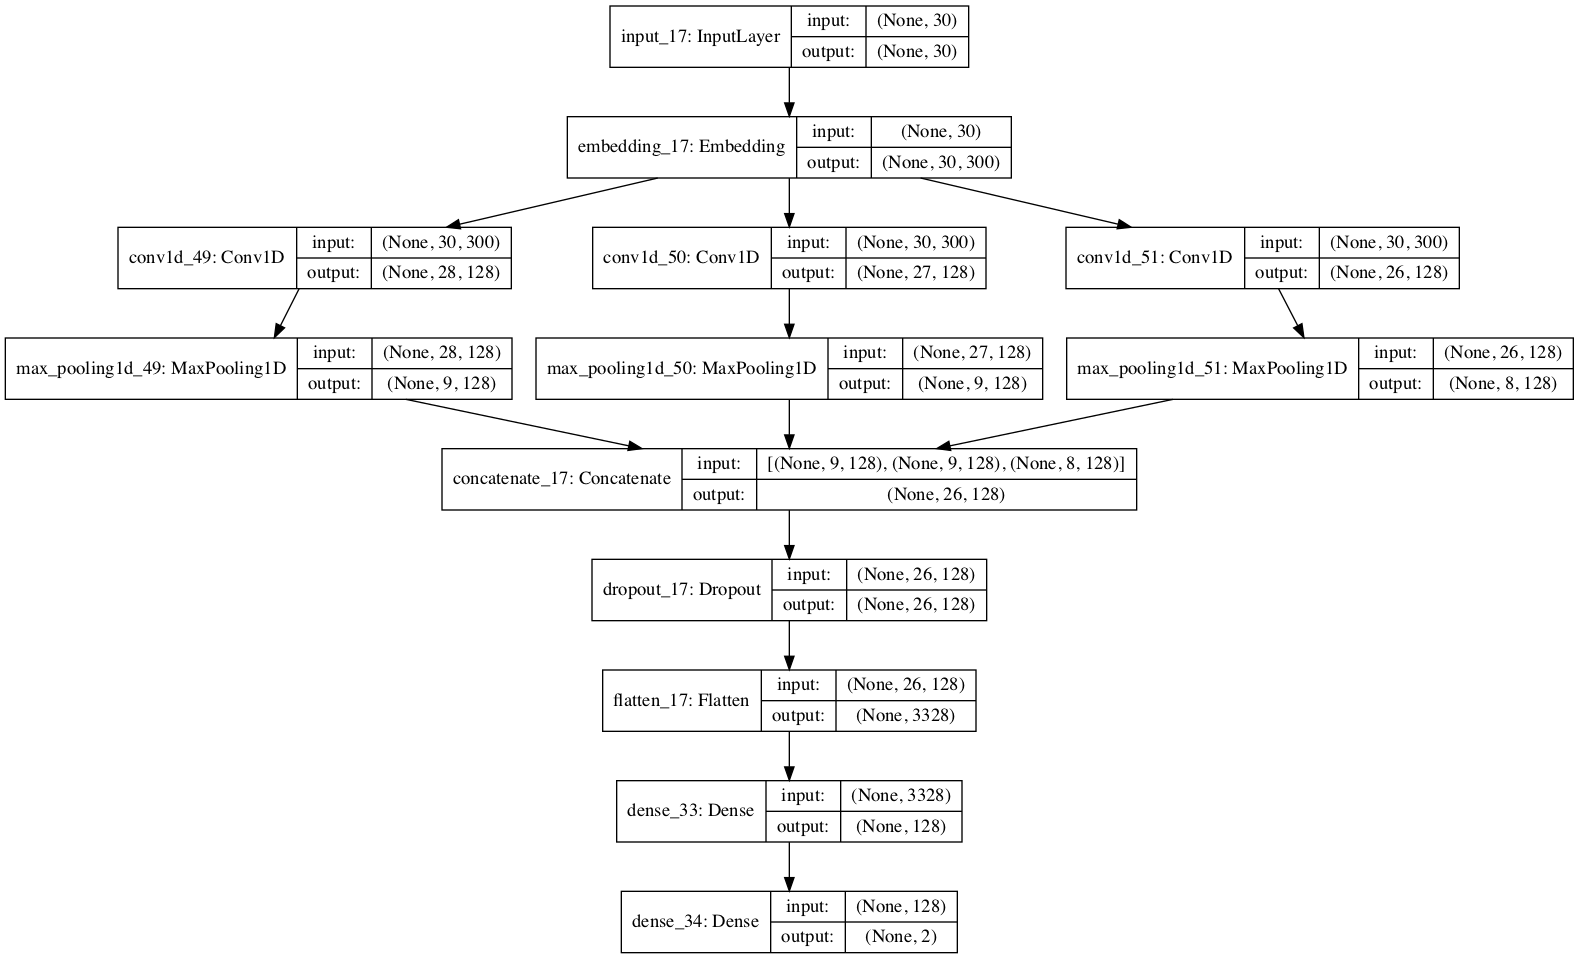

In [316]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [317]:
model.fit(x_train_cnn, y_train_cnn, epochs=11, batch_size=128)

Epoch 1/11
5329/5329 [==============================] - 5s 979us/step - loss: 0.5486 - acc: 0.7324
Epoch 2/11
5329/5329 [==============================] - 4s 756us/step - loss: 0.3915 - acc: 0.8322
Epoch 3/11
5329/5329 [==============================] - 4s 751us/step - loss: 0.3060 - acc: 0.8763
Epoch 4/11
5329/5329 [==============================] - 4s 766us/step - loss: 0.2253 - acc: 0.9165
Epoch 5/11
5329/5329 [==============================] - 5s 890us/step - loss: 0.1741 - acc: 0.9401
Epoch 6/11
5329/5329 [==============================] - 4s 814us/step - loss: 0.1455 - acc: 0.9557
Epoch 7/11
5329/5329 [==============================] - 5s 867us/step - loss: 0.1209 - acc: 0.9625
Epoch 8/11
5329/5329 [==============================] - 6s 1ms/step - loss: 0.1148 - acc: 0.9653
Epoch 9/11
5329/5329 [==============================] - 4s 818us/step - loss: 0.0944 - acc: 0.9683
Epoch 10/11
5329/5329 [==============================] - 4s 834us/step - loss: 0.0833 - acc: 0.9737
Epoch 11/11

In [369]:
y_predicted_cnn = model.predict(x_test_cnn)
y_predicted_cnn[:5]

array([[0.99663144, 0.00336853],
       [0.9690748 , 0.03092514],
       [0.1405367 , 0.8594633 ],
       [0.8972368 , 0.10276315],
       [0.99279237, 0.00720764]], dtype=float32)

In [370]:
def classify_results(y_predicted):
    y_predicted[y_predicted > 0.5] = 1
    y_predicted[y_predicted <= 0.5] = 0
    return y_predicted
y_predicted_cnn_classifed = classify_results(y_predicted_cnn)
y_predicted_cnn_classifed[:5]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [371]:
accuracy_cnn, precision_cnn, recall_cnn, f1_cnn = get_metrics(y_test_cnn[:, [1]], y_predicted_cnn_classifed[:, [1]])
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_cnn, precision_cnn, 
                                                                       recall_cnn, f1_cnn))

accuracy = 0.808, precision = 0.807, recall = 0.808, f1 = 0.806


In [368]:
cf = confusion_matrix(y_predicted_cnn_classifed[:, [1]],y_test_cnn[:, [1]])
cf

array([[1128,  263],
       [ 176,  717]])

In [322]:
import itertools   
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.81092739 0.18907261]
 [0.19708847 0.80291153]]


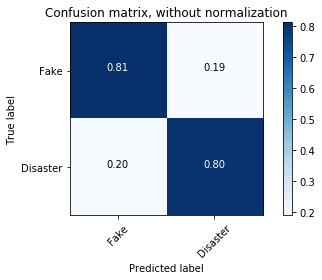

In [323]:
plot_confusion_matrix(cf, classes=classes,
                      title='Confusion matrix, without normalization',
                     normalize=True)

Confusion matrix, without normalization
[[1128  263]
 [ 176  717]]


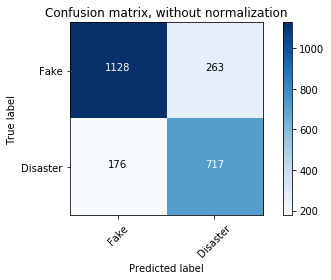

In [367]:
plot_confusion_matrix(cf, classes=classes,
                      title='Confusion matrix, without normalization',
                     normalize=False)

In [325]:
def cnn_pipeline(examples):
    sequences_list = tokenizer.texts_to_sequences(examples) 
    data = pad_sequences(sequences_list, maxlen=MAX_SEQUENCE_LENGTH)
    prediction = model.predict(data)
   
    return prediction

In [326]:
def explain_one_instance_cnn(instance, class_names):
    explainer_cnn = LimeTextExplainer(class_names=class_names)
    exp = explainer_cnn.explain_instance(instance, cnn_pipeline, num_samples=5000)
    return exp

def visualize_one_exp_cnn(features, labels, index, class_names = ["irrelevant","relevant"]):
    exp = explain_one_instance_cnn(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [335]:
visualize_one_exp_cnn(x_test_cnn_raw, y_test_cnn_raw, 89)

Index: 89
True class: relevant


In [328]:
visualize_one_exp_cnn(x_test_cnn_raw, y_test_cnn_raw, 20)

Index: 20
True class: irrelevant


In [336]:
def get_statistical_explanation_cnn(test_set, sample_size, cnn_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer_cnn_again = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = cnn_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer_cnn_again.explain_instance(sentence, cnn_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

sorted_contributions_cnn = get_statistical_explanation_cnn(x_test_cnn_raw, 100, cnn_pipeline, y_test_cnn_raw)

/Users/kayash/.conda/envs/big_data/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [337]:
sorted_contributions_cnn.keys()

dict_keys([0])

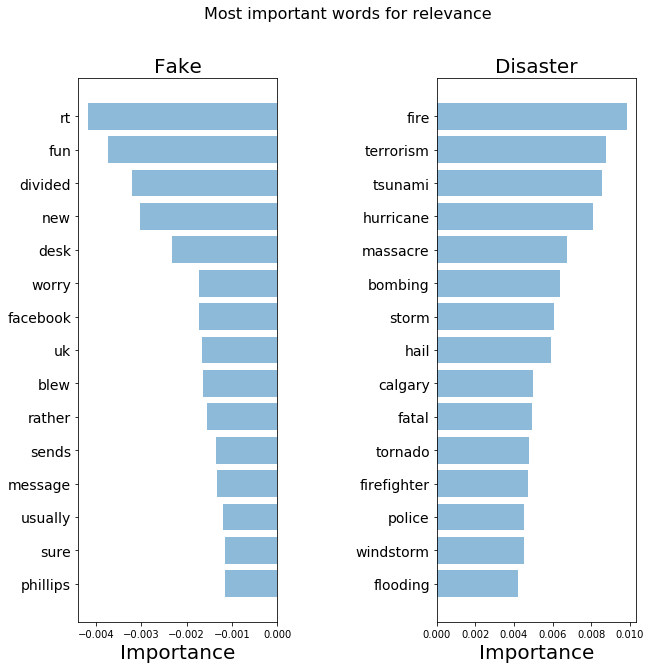

In [338]:
# First index is the class (Disaster)
# Second index is 0 for detractors, 1 for supporters
# Third is how many words we sample
top_words_cnn = sorted_contributions_cnn[0]['supporters'][:15].index.tolist()
top_scores_cnn = sorted_contributions_cnn[0]['supporters'][:15].tolist()
bottom_words_cnn = sorted_contributions_cnn[0]['detractors'][:15].index.tolist()
bottom_scores_cnn = sorted_contributions_cnn[0]['detractors'][:15].tolist()

plot_important_words(top_scores_cnn, top_words_cnn, bottom_scores_cnn, bottom_words_cnn, "Most important words for relevance")

**Исследуем CNN глубже**

In [339]:
y_test_cnn_df = pd.DataFrame(y_test_cnn[:, [1]])

In [340]:
y_predicted_cnn_classifed_df = pd.DataFrame(y_predicted_cnn_classifed[:, [1]])

In [341]:
k = 0
indexes = []
for i in y_predicted_cnn_classifed_df[0]:
    if i != y_test_cnn_df[0][k]:
        indexes.append(k)
    k += 1

In [342]:
len(indexes)

439

Сохраним полученную модель

In [372]:
# serialize to JSON
json_file = model.to_json()
with open('readyModels/cnnModel.json', "w") as file:
   file.write(json_file)

# serialize weights to HDF5
model.save_weights('readyModels/cnnModelWeights.hdf5')

In [373]:
from keras.models import model_from_json
import json

In [374]:
# load json and create model
file = open('readyModels/cnnModel.json', 'r')
model_json = file.read()
file.close()
loaded_model = model_from_json(model_json)

In [375]:
# load weights
loaded_model.load_weights('readyModels/cnnModelWeights.hdf5')